# Face Recognition

In [16]:
from imutils.video import VideoStream
import face_recognition
import argparse
import imutils
import pickle
import time
import cv2

import numpy as np
import matplotlib.pyplot as plt

from keras.models import model_from_json

import dlib

from imutils import face_utils

In [17]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Finding Attention/shape_predictor_5_face_landmarks.dat")
predictor_2 = dlib.shape_predictor("../DontSleep/shape_predictor_68_face_landmarks.dat")

In [18]:
def predict(X_img, knn_clf=None, model_path=None, distance_threshold=0.4):
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    X_face_locations = face_recognition.face_locations(X_img,model='hog')

    if len(X_face_locations) == 0:
        return []

    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)

    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

In [19]:
cam = cv2.VideoCapture(0)

In [20]:
_ , frame_init = cam.read()

Verified = False

while True:

    ret,frame = cam.read()
    
    blended = cv2.addWeighted(src1 = frame_init , alpha = 0.6 , src2 = frame , beta = 0.4 , gamma = 0)
    
    if frame is not None:
        
        predictions = predict(blended, model_path='SavedModel')
        
        Name = "None"
        
        for (name,(top, right, bottom, left)) in predictions:
            
            if name == "unknown":
                cv2.imshow("Frame", frame)
                
            else :
                
                Name = name 
                Verified = True
                cv2.rectangle(frame, (left, top), (right, bottom),(0, 255, 0), 2)
                y = top - 15 if top - 15 > 15 else top + 15
                cv2.putText(frame, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,0.75, (0, 255, 0), 2)
                cv2.imshow("Frame", frame)
                
                print(" Verfied as " , name)
            
        if Name != "None":
            break
            
        _ , frame_exit = cam.read()
        
        frame_init = frame_exit
        
cam.release()
cv2.destroyAllWindows()

 Verfied as  abhi


# Grooming module

 men 
 Well Groomed 


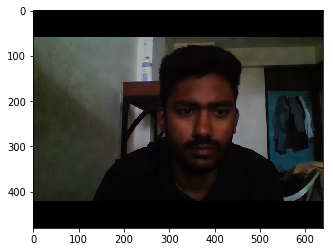

In [21]:
from torch import nn , optim
import torch 

from torchvision import datasets , transforms , models 

from torch.utils.data import DataLoader 

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler , SequentialSampler

from collections import OrderedDict

from PIL import Image

device = "cpu"

model = models.resnet34()

model.fc = nn.Sequential(OrderedDict([
            ('fcl1', nn.Linear(512,256)),
            ('dp1', nn.Dropout(0.3)),
            ('r1', nn.ReLU()),
            ('fcl2', nn.Linear(256,32)),
            ('dp2', nn.Dropout(0.3)),
            ('r2', nn.ReLU()),
            ('fcl3', nn.Linear(32,1)),
            ('Sig', nn.Sigmoid()),
        ]))

model.load_state_dict(torch.load("man_vs_woman_weights.pth", map_location='cpu'))

model.to(device)

cam = cv2.VideoCapture(0)

ret , frame = cam.read()

frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

PIL_img = Image.fromarray(frame).convert('RGB')

def load_image(PIL_img, size = 224):
        
    in_transform = transforms.Compose([
                        transforms.Resize((size,size)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(PIL_img)[:3,:,:].unsqueeze(0)
    
    return image

image = load_image(PIL_img)
image = image.to(device)

with torch.no_grad():
    model.eval()
    output = model(image)
    val = output.cpu().numpy()
    
if val[0][0] < 0.5 :
    print(" men ")
    
    model.load_state_dict(torch.load("Grooming_weights.pth", map_location='cpu'))
    
    with torch.no_grad():
        model.eval()
        output = model(image)
        val = output.cpu().numpy()
        
    if val[0][0] < 0.5 :
        print(" Not Well Groomed ")
    else :
        print(" Well Groomed ")
        
else :
    print(" woman ")
    
    model.load_state_dict(torch.load("Grooming_women.pth", map_location='cpu'))
    
    with torch.no_grad():
        model.eval()
        output = model(image)
        val = output.cpu().numpy()
        
    if val[0][0] < 0.5 :
        print(" Not Well Groomed ")
    else :
        print(" Well Groomed ")
    
plt.imshow(frame)

# Comfortable + Attention

In [22]:
#Face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [23]:
def ProcessImage( Img , resize = True , size = 64 , Normalize = True , blur = True): 
    
    if Normalize == True :
        Img = Img / 255.0
        
    if resize == True :
        Img = cv2.resize( Img , (size , size) )
        
    if blur == True :
        Img = cv2.GaussianBlur( Img , (5,5) , 0 ) 
        
    return Img 

In [24]:
mu , std = np.load("params.npy")

In [25]:
json_file = open("model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


loaded_model.load_weights("model.h5")
print("Loaded model from disk")


loaded_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Loaded model from disk


In [26]:
def Output(pred):
    
    if pred == 0 or pred == 1 or pred == 2 or pred == 4 or pred == 5 :
        return "Not Comfortable"
    
    elif pred == 3 :
        return "Comfortable"
    
    else :
        return "Moderate"

In [27]:
def distance(pt1 , pt2):
    return np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)

In [28]:
def GetRatio(shape):
    Right = distance(shape[3],shape[30])
    Left = distance(shape[30],shape[13])
    
    return Right/Left

def shape_np_array(shape):
    
    co_ordinates = np.zeros((68,2) , dtype = "int")
    
    for i in range(0,68):
        co_ordinates[i] = (shape.part(i).x , shape.part(i).y)
        
    return co_ordinates

In [29]:
VideoCapture = cv2.VideoCapture(0)

In [30]:
#eye_Cascade_File = cv2.CascadeClassifier('haarcascade_eye.xml')

if Verified == True :
    while True :
    
        ret , frame = VideoCapture.read() 
    
        if not ret :
            break
        
        gray = cv2.cvtColor( frame , cv2.COLOR_BGR2GRAY)
        
        rects = detector(gray, 0)
    
        for rect in rects :
            (x , y , w , h) = face_utils.rect_to_bb(rect)            
            img = gray[y : y+h , x : x+w]
            roi_color = frame[y : y+h , x : x+w]
            
            #eyes = eye_Cascade_File.detectMultiScale(img)
            
            #for (ex, ey, ew, eh) in eyes:
             #   cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
    
            Img = ProcessImage(img)

            Img = Img.reshape(1,64,64,1)

            Img = (Img - mu) / std

            pred = loaded_model.predict(Img)
        
            pred = np.argmax(pred)
        
            out = Output(pred)
            
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            
            shape_2 = predictor_2(gray , rect)
        
            shape_2 = shape_np_array(shape_2)
            
            Tot_R = GetRatio(shape_2)
            
            if Tot_R > 5 :
                att_2 = " Looking Left "
                cv2.putText(frame, att_2, (x - 20, y - 43),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            elif Tot_R < 0.5 :
                att_2 = " Looking Right "
                cv2.putText(frame, att_2, (x - 20, y - 43),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        
            ratio = distance(shape[0],shape[2]) / distance((shape[0] + shape[2])/2,shape[4])
            
            if ratio < 1.6:
                att = "not paying attention"
                
            else :
                att = "paying attention"
        
            cv2.rectangle(frame, (x, y), (x+w, y+h),(0, 255, 0), 1)
            z = y - 15 if y - 15 > 15 else y + 15
            cv2.putText(frame, out, (x, z), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 1)
            cv2.putText(frame, att, (x - 10, y - 30),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            cv2.imshow("Frame", frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        _ , frame_exit = VideoCapture.read()
        
        frame_init = frame_exit
        
VideoCapture.release()
cv2.destroyAllWindows()